# Producing multiple peaked synthetic profiles
## Background
It is standard practice in flood modelling to use design rainfall profiles generated by FEH/ReFH2. We are interested in examining whether distributing rainfall over time in multiple peaks, rather than just one, will result in a different flooding outcome. 

## Constructing synthetic multiple peaked events
The FEH single-peak profiles are always produced with a single peak which can be characterised by:
1) The total corresponding rainfall volume $V$.  
2) The duration $d$ (start to end).  
3) The shape of the peak, defined here: https://refhdocs.hydrosolutions.co.uk/Design-DDF-Rainfall-Hyetographs/Design-Storm-Profiles/  
 
To construct multiple peaked events, we need to consider:  
 1) The rainfall volume$ V_1,...V_N$ for each peak. Suggestion: use $V/N$, so we have the same total rainfall.  
 2) The shape of each peak. Suggestion: use the same shape, but different peak rainfall height so it gives the desired volume  given a start-to-end duration for the peak.  
 3) The start-to-end duration of each peak. This is a parameter we can play with, but probably we will mainly look at short durations.  
 4) The spacing between peaks. Here, the question is what a "fair" spacing for comparison so that the overall "event duration" is the same, and this is probably a bit subjective. We could also consider this as another parameter to play with.  
 


In [1]:
from datetime import datetime, timedelta
import pandas as pd
from dateutil.relativedelta import relativedelta
import sys
import matplotlib.patches as mpatches
from matplotlib import dates as mdates
import re
sys.path.insert(1, '../')
from Functions import *

### Define the different methods 

In [44]:
methods=['single-peak','divide-time','max-spread','subpeak-timing']
durations = ['1h', '3h', '6h']

### Create dataframe for one method containing the accumulation and rate at each minute of time

In [47]:
# For each method produce a dataframe containing precipitation values for each minute and save these to file
for duration in ['6h']:
    for method in methods:
        print(method, duration)
        ## PARAMETER SETTINGS
        N_subpeaks= 3
        total_duration_minutes= int(duration[0]) * 60
        subpeak_duration_minutes=total_duration_minutes/6
        if duration == '1h':
            total_mm_accum= 38.7
        elif duration == '3h':
            total_mm_accum= 51.3
        elif duration == '6h':
              total_mm_accum=  59.98
        default_peak_shape='refh2-summer'

        if len(re.findall("\d+\.\d+", method))>0:
            peak_before_frac = float(re.findall("\d+\.\d+", method)[0])
        else:
            peak_before_frac = 0.5
                
        # Create datetimes to go with values
        start = datetime(2022,8,1,0,0,0)
        end = start + relativedelta(hours=int(duration[0]))
        end = end - timedelta(minutes=1) 
        seconds = (end - start).total_seconds() + 60
        step = timedelta(minutes=1)
        datetimes = []
        for i in range(0, int(seconds), int(step.total_seconds())):
            datetimes.append(start + timedelta(seconds=i))       
        
        # Find accumulation and rate
        accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes,peak_before_frac)
        # Create as dataframe
        accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
        # Keep only columns needed for feeding to ReFH2
        accum_df = accum_df[['Dates','Rate (mm/min)']]
        # Write to csv
        accum_df.to_csv("{}r_100yrRP/PreLossRemoval/{}_{}.csv".format(duration,duration, method),
                       header = False, index = False)
#         print(accum_df['Rate (mm/min)'].max())

single-peak 6h
divide-time 6h
max-spread 6h
subpeak-timing 6h


### Create a single peaked profile with 10% extra volume

In [10]:
method = 'single-peak'
duration = '6h'
N_subpeaks = 1
total_duration_minutes= int(duration[0]) * 60
subpeak_duration_minutes=total_duration_minutes/6
total_mm_accum=  65.978 # 59.98
default_peak_shape='refh2-summer'
peak_before_frac = 0.5

# Create datetimes to go with values
start = datetime(2022,8,1,0,0,0)
end = start + relativedelta(hours=int(duration[0]))
end = end - timedelta(minutes=1) 
seconds = (end - start).total_seconds() + 60
step = timedelta(minutes=1)
datetimes = []
for i in range(0, int(seconds), int(step.total_seconds())):
    datetimes.append(start + timedelta(seconds=i))       

# Find accumulation and rate
accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,subpeak_duration_minutes,peak_before_frac)
# Create as dataframe
accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
# Keep only columns needed for feeding to ReFH2
accum_df = accum_df[['Dates','Rate (mm/min)']]

# Write to csv
accum_df.to_csv("{}r_100yrRP/PreLossRemoval/{}_{}_+10%volume.csv".format(duration,duration, method),
               header = False, index = False)

## Plot pre loss removal profiles

In [30]:
methods=['6h_single-peak','6h_divide-time','6h_max-spread','6h_subpeak-timing']
# methods=['6h_single-peak_+10%volume']

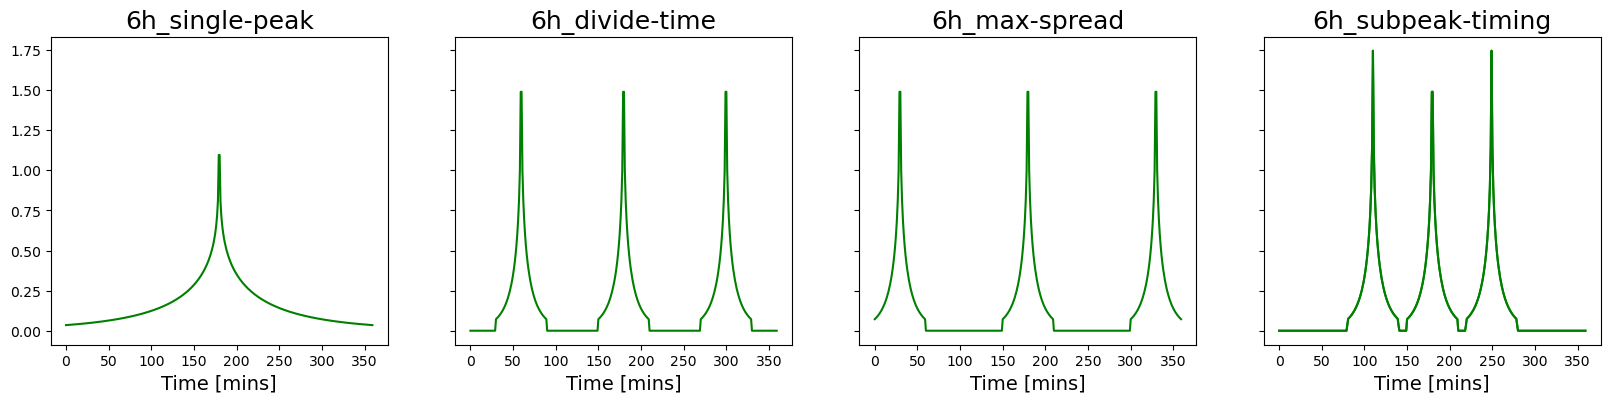

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (20,4), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for number, ax in enumerate(axs.reshape(-1)): 
    plot_profile_shape_prelossremoval(ax, methods[number], "../SyntheticProfiles/")
plot_profile_shape_prelossremoval(ax, methods[number], "../SyntheticProfiles/")    

### Plot single peak profile with +10% volume

In [ ]:
pre_loss_removal = pd.read_csv("6hr_100yrRP/PreLossRemoval/6h_single-peak_+10%volume.csv", names =['Time', 'Rain'])
pre_loss_removal['Time'] =  np.array(range(total_duration_minutes)) 
fig,ax=plt.subplots(figsize=(4,4))
plt.plot(pre_loss_removal['Time'], pre_loss_removal['Rain'], color = 'green');
pre_loss_removal['Rain'].max()

# Plot post loss removal profiles

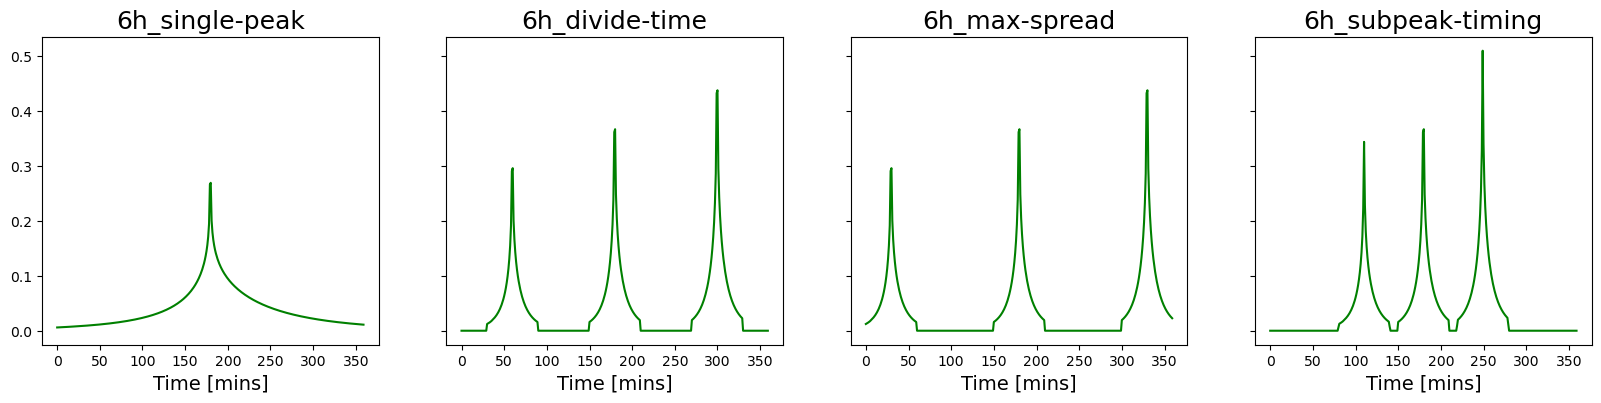

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (20,4), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for number, ax in enumerate(axs.reshape(-1)): 
    plot_profile_shape_postlossremoval(ax, methods[number],"../SyntheticProfiles/")

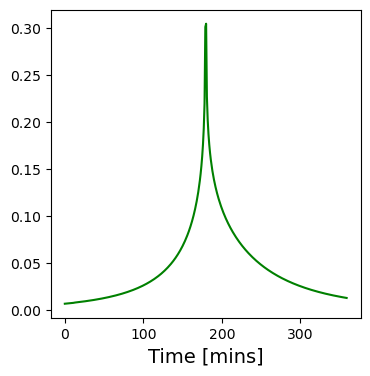

In [51]:
fig,ax=plt.subplots(figsize=(4,4))
post_loss_removal = pd.read_csv("6hr_100yrRP/PostLossRemoval/6h_single-peak_+10%volume.csv")
# Filter to only include those within the first 6 hours
post_loss_removal = post_loss_removal[:360]
# Convert date to datetime
post_loss_removal['Time'] =  np.array(range(total_duration_minutes))     
# PLot
plt.plot(post_loss_removal['Time'], post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color = 'green')
plt.xlabel('Time [mins]', fontsize = 14);